# 4.2 다이닝코드 웹페이지 데이터 크롤링

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: 크롤링으로 웹 데이터 가져오기

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import re
import time

# 크롤링할 사이트 주소를 정의
source_url = "https://www.diningcode.com/"

options = webdriver.ChromeOptions() # 크롭 브라우저의 옵션을 설정
service = Service(executable_path=ChromeDriverManager().install()) # 운영체제에 맞는 크롭 드라이버를 자동 설치

# 사이트의 html 구조에 기반하여 크롤링을 수행
driver = webdriver.Chrome(options=options, service=service) # 크롭 웹 드라이브를 초기화 후 옵션 전달하여 브라우저를 엶
driver.get(source_url) # 해당 url로 브라우저를 이동

# 검색창에 검색어를 입력 후 ENTER 키 누르기
search_keyword = "종로"
searchbox = driver.find_element(By.XPATH, '//*[@id="root"]/header/div/div/div[2]/div/input')
searchbox.send_keys(search_keyword)
searchbox.send_keys(Keys.RETURN)

# 검색 결과를 가져올 시간을 기다림
time.sleep(2)

# 검색 결과 페이지 소스 가져오기
html = driver.page_source

# # BeautifulSoup을 이용하여 html 정보를 파싱
soup = BeautifulSoup(html, "html.parser")
restaurants = soup.find_all(name="a", attrs={"class":"sc-hLQRIN uMLYs Poi__Block"})

# # a태그의 href 속성을 리스트로 추출하여, 크롤링 할 페이지 리스트를 생성
page_urls = []
for restaurant in restaurants:
    page_url = restaurant.get("href")
    print(page_url)
    page_urls.append(page_url)

# 크롤링에 사용한 브라우저를 종료
driver.close()

/profile.php?rid=YltfTH9OOS0u
/profile.php?rid=hVe913EGlSv8
/profile.php?rid=QlMrlKl3A6ry
/profile.php?rid=c8gUAYLmlXzW
/profile.php?rid=Te0e56ZL6lxA


In [3]:
columns = ['score', 'review']
df = pd.DataFrame(columns=columns)

driver = webdriver.Chrome(options=options, service=service)

url = source_url + page_urls[0]

# 페이지에 접속
driver.get(url)
time.sleep(2)

# 더보기 버튼 눌러 모든 리뷰 보이게 하기
more_review_button = driver.find_element(By.XPATH, '//*[@id="div_more_review"]/button')
while True:
    try: 
        more_review_button.send_keys(Keys.RETURN)
        time.sleep(1)
    except:
        break
time.sleep(2)

# 페이지 소스 가져오기
html = driver.page_source
soup = BeautifulSoup(html, "html.parser")
contents_div = soup.find(name="div", attrs={"id":"div_review"})

# 별점 가져오기
rates = contents_div.find_all(name="span", attrs={"class":"total_score"})

# 리뷰 가져오기
reviews = contents_div.find_all(name="p", attrs={"class":"review_contents btxt"})

for rate, review in zip(rates, reviews):
    new_df = pd.DataFrame({'score':[rate.text[0]], 'review':[review.text]})
    df = pd.concat([df, new_df], ignore_index=True)

# 크롤링에 사용한 브라우저를 종료
driver.close()

df.head()

,score,review
0,5,"웨이팅하기로 유명한 돈가스집인데, 운이 좋게도 금요일 오후에 10분정도만 기다리고 ..."
1,5,지하1층에 위치해서 조금 찾기 어려울 수도 있지만 지도 보고 가시면 금방 찾을 수 ...
2,5,돈가스 너무 맛있고 직원분이 친절해서 좋았어요 \n새우튀김도 간 적당하구 맛있어요
3,5,오후 5시에 오픈런해서 들어갔어요. 돈까스가 원래 느끼함이 있어서 먹다보면 질리는 ...
4,5,웨이팅 필수! 나는 도착했을때 기다림 없이 들어 갈 수 있었음 돈까스 맛집


In [4]:
len(df)

150

In [5]:
# 4점 이상 리뷰는 긍정 리뷰, 3점 이하 리뷰는 부정 리뷰로 평가
df['y'] = df['score'].apply(lambda x: 1 if float(x) > 3 else 0)
df.head()

,score,review,y
0,5,"웨이팅하기로 유명한 돈가스집인데, 운이 좋게도 금요일 오후에 10분정도만 기다리고 ...",1
1,5,지하1층에 위치해서 조금 찾기 어려울 수도 있지만 지도 보고 가시면 금방 찾을 수 ...,1
2,5,돈가스 너무 맛있고 직원분이 친절해서 좋았어요 \n새우튀김도 간 적당하구 맛있어요,1
3,5,오후 5시에 오픈런해서 들어갔어요. 돈까스가 원래 느끼함이 있어서 먹다보면 질리는 ...,1
4,5,웨이팅 필수! 나는 도착했을때 기다림 없이 들어 갈 수 있었음 돈까스 맛집,1


## Step 2 텍스트 전처리: 분류 모델 피처로 변환하기

아래 코드는 한글 문자열만 필터링하는 과정이다.

In [6]:
import re

# 텍스트 정제 함수: 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    # 한글의 정규 표현식으로 한글만 추출
    hangul = re.compile('[^ ㄱ-힣]+')
    result = hangul.sub('', text)
    return result

# 함수를 적용하여 리뷰에서 한글만 추출
df['review'] = df['review'].apply(lambda x: text_cleaning(x))
df.head()

,score,review,y
0,5,웨이팅하기로 유명한 돈가스집인데 운이 좋게도 금요일 오후에 분정도만 기다리고 입장했...,1
1,5,지하층에 위치해서 조금 찾기 어려울 수도 있지만 지도 보고 가시면 금방 찾을 수 있...,1
2,5,돈가스 너무 맛있고 직원분이 친절해서 좋았어요 새우튀김도 간 적당하구 맛있어요,1
3,5,오후 시에 오픈런해서 들어갔어요 돈까스가 원래 느끼함이 있어서 먹다보면 질리는 경향...,1
4,5,웨이팅 필수 나는 도착했을때 기다림 없이 들어 갈 수 있었음 돈까스 맛집,1


아래 코드는 형태소를 추출하는 전처리 과정이다.

In [7]:
from konlpy.tag import Okt

# konlpy 라이브러리로 텍스트 데이터에서 형태소를 추출
def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word, tag) for word, tag in pos]
    return pos

# 형태소 추출 동작을 테스트
result = get_pos(df['review'].values[0])
print(result)

['웨이/Noun', '팅/Noun', '하기로/Verb', '유명한/Adjective', '돈가스/Noun', '집/Noun', '인데/Josa', '운/Noun', '이/Josa', '좋게도/Adjective', '금요일/Noun', '오후/Noun', '에/Josa', '분/Noun', '정도/Noun', '만/Josa', '기다리고/Verb', '입장/Noun', '했어요/Verb', '등심/Noun', '보다는/Josa', '안심/Noun', '이/Josa', '부드러워서/Adjective', '안심/Noun', '카츠/Noun', '를/Josa', '시켰는데/Verb', '정말/Noun', '촉촉하고/Adjective', '바삭/Noun', '했어요/Verb', '카레/Noun', '단/Modifier', '품/Noun', '도/Josa', '추가/Noun', '해서/Verb', '밥/Noun', '하고/Josa', '비벼/Verb', '먹었는데/Verb', '카레/Noun', '좋아하시는/Adjective', '분/Noun', '들/Suffix', '은/Josa', '꼭/Noun', '추가/Noun', '해서/Verb', '같이/Adverb', '드세요/Verb', '규/Noun', '카츠/Noun', '같이/Josa', '양초/Noun', '로/Josa', '데워/Verb', '먹을/Verb', '수/Noun', '있어서/Adjective', '마지막/Noun', '까지/Josa', '따뜻하게/Adjective', '먹을/Verb', '수/Noun', '있었습니다/Adjective']


이제 텍스트 데이터를 분류 모델에 학습이 가능한 데이터셋으로 만들어보자

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 벡터 형태의 학습 데이터셋으로 변환
index_vectorizer = CountVectorizer(tokenizer= lambda x: get_pos(x))
X = index_vectorizer.fit_transform(df['review'].tolist())
print(X.shape)

C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(150, 1765)


학습 데이터셋과 말뭉치가 올바르게 생성되었는지 확인해보자

In [9]:
print(str(index_vectorizer.vocabulary_)[:100] + "..")

{'웨이/Noun': 1212, '팅/Noun': 1614, '하기로/Verb': 1657, '유명한/Adjective': 1219, '돈가스/Noun': 453, '집/Noun'..


아래 결과는 원래 텍스트 데이터와 변환 이후의 데이터를 함께 출력한 것이다. 아래의 문장이 여러 개의 벡터로 변환된 것을 알 수 있다.

In [10]:
print(df['review'][0])
print(X[0])

웨이팅하기로 유명한 돈가스집인데 운이 좋게도 금요일 오후에 분정도만 기다리고 입장했어요등심보다는 안심이 부드러워서 안심카츠를 시켰는데 정말 촉촉하고 바삭했어요 카레단품도 추가해서 밥하고 비벼먹었는데 카레 좋아하시는 분들은 꼭 추가해서 같이 드세요 규카츠같이 양초로 데워먹을 수 있어서 마지막까지 따뜻하게 먹을 수 있었습니다
  (0, 1212)	1
  (0, 1614)	1
  (0, 1657)	1
  (0, 1219)	1
  (0, 453)	1
  (0, 1499)	1
  (0, 1296)	1
  (0, 1203)	1
  (0, 1243)	2
  (0, 1435)	1
  (0, 196)	1
  (0, 1177)	1
  (0, 1132)	1
  (0, 836)	2
  (0, 1415)	1
  (0, 578)	1
  (0, 209)	1
  (0, 1322)	1
  (0, 1724)	2
  (0, 527)	1
  (0, 791)	1
  (0, 1043)	2
  (0, 816)	1
  (0, 1568)	2
  (0, 566)	1
  :	:
  (0, 444)	1
  (0, 1550)	2
  (0, 1707)	2
  (0, 764)	1
  (0, 1653)	1
  (0, 854)	1
  (0, 680)	1
  (0, 1445)	1
  (0, 506)	1
  (0, 1230)	1
  (0, 263)	1
  (0, 90)	1
  (0, 499)	1
  (0, 165)	1
  (0, 91)	1
  (0, 1084)	1
  (0, 562)	1
  (0, 441)	1
  (0, 699)	2
  (0, 942)	2
  (0, 1345)	1
  (0, 574)	1
  (0, 249)	1
  (0, 529)	1
  (0, 1353)	1


텍스트 데이터에 중복되는 형태소가 존재하면 어떻게 될까? 같은 데이터로 변환이 되는데, 이러한 문제를 해결하기 위해 텍스트를 피처로 만드는 TF-IDF 방법을 적용해보자

TF-IDF는 단어 빈도를 나타내는 TF와 문서 빈도를 나타내는 DF의 역수 IDF를 곱한 값을 의미한다. 만약 1번 텍스트에 '맛집'이라는 단어가 3번 등장하고, 모든 데이터에서 '맛집'이라는 단어가 10개 등장할 때, TF 값은 3, IDF 값은 0.1이 된다. 따라서 TF-IDF는 다른 문서들에서는 등장하지 않았지만 현재 문서에서는 많이 등장하는 단어를 의미하며, 그 단어가 현재 문서에서 얼마나 중요한지를 피처로 나타낼 수 있다.

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF 방법으로 형태소를 벡터 형태의 학습 데이터셋으로 변환
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

print(X.shape)
print(X[0])

(150, 1765)
  (0, 90)	0.12146432666616074
  (0, 91)	0.13554085016655223
  (0, 165)	0.1467140154451366
  (0, 196)	0.1467140154451366
  (0, 209)	0.12146432666616074
  (0, 249)	0.11219235766995096
  (0, 263)	0.10851271103738466
  (0, 403)	0.12761336324126063
  (0, 441)	0.1467140154451366
  (0, 444)	0.06091669170124009
  (0, 453)	0.08941205883350868
  (0, 499)	0.1467140154451366
  (0, 506)	0.0973395457588003
  (0, 527)	0.06281788798361465
  (0, 529)	0.1467140154451366
  (0, 562)	0.09973726747832985
  (0, 566)	0.07208985697982444
  (0, 574)	0.1467140154451366
  (0, 578)	0.10526703268409193
  (0, 680)	0.10851271103738466
  (0, 699)	0.1946790915176006
  (0, 756)	0.10851271103738466
  (0, 764)	0.12761336324126063
  (0, 791)	0.12146432666616074
  (0, 816)	0.12761336324126063
  :	:
  (0, 1177)	0.13554085016655223
  (0, 1203)	0.13554085016655223
  (0, 1212)	0.07302406224804153
  (0, 1219)	0.09309170546607497
  (0, 1230)	0.061535963070577904
  (0, 1243)	0.08743447155947734
  (0, 1296)	0.1052670326

## Step 3 분류: 긍정/부정 리뷰 분류하기

In [12]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(x_train.shape)
print(x_test.shape)

(105, 1765)
(45, 1765)


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 로지스틱 회귀 모델을 학습
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 로지스틱 회귀 모델의 성능을 평가
print('accuracy: %.2f' %accuracy_score(y_test, y_pred))
print('Precision: %.3f' %precision_score(y_test, y_pred))
print('Recall: %.3f' %recall_score(y_test, y_pred))
print('F1: %.3f' %f1_score(y_test, y_pred))

accuracy: 0.89
Precision: 0.889
Recall: 1.000
F1: 0.941


아래 결과를 보면 결과가 조금 이상하다. 분류 모델은 모든 데이터를 1로 예측하고 있다. 모델이 하나의 결과만을 예측하도록 잘못 학습이 된것이다. 이런 현상을 **클래스의 불균형 문제**라고 한다. 이는 데이터의 Positive sample과 Negative sample의 비율이 크게 차이가 나는 경우에 발생한다. 그래서 적절한 샘플링 방법을 통해 클래스의 불균형 문제를 해결한다.

In [14]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[ 0  5]
 [ 0 40]]


Positive, Negative 비율을 살펴보자

In [15]:
df['y'].value_counts()

y
1    136
0     14
Name: count, dtype: int64

거의 9:1인 것을 확인할 수 있다.

Negative 수가 넘 적긴 하지만 클래스를 1:1 비율로 샘플링하기 위해 y가 1인 10개의 샘플, y가 0인 10개의 샘플을 임의로 추출해보자

In [16]:
# 1:1 비율로 랜덤 샘플링을 추출
positive_random_idx = df[df['y'] == 1].sample(10, random_state=30).index.tolist()
negative_random_idx = df[df['y'] == 0].sample(10, random_state=30).index.tolist()

# 랜덤 데이터로 데이터 셋을 나눔
random_idx = positive_random_idx + negative_random_idx
sample_X = X[random_idx, :]
y = df['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(sample_X, y, test_size=0.3)
print(x_train.shape)
print(x_test.shape)

(14, 1765)
(6, 1765)


아무래도 표본이 너무 적어서 정확도가 낮게 나온 것 같다..

In [17]:
# 로지스틱 회귀 모델을 학습
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 로지스틱 회귀 모델의 성능을 평가
print('accuracy: %.2f' %accuracy_score(y_test, y_pred))
print('Precision: %.3f' %precision_score(y_test, y_pred))
print('Recall: %.3f' %recall_score(y_test, y_pred))
print('F1: %.3f' %f1_score(y_test, y_pred))

accuracy: 0.17
Precision: 0.167
Recall: 1.000
F1: 0.286


In [18]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[0 5]
 [0 1]]


## Step 4 분석: 중요 키워드 분석하기

[(0.18019141091928803, 902), (0.17015112893474563, 1417), (0.16313584515747545, 628), (0.134875852880829, 325), (0.13149207883807337, 949)]
[(-0.17434785981350073, 1243), (-0.20130821540890526, 1387), (-0.23138125960209766, 433), (-0.23235561915810354, 219), (-0.3232769545470655, 10)]


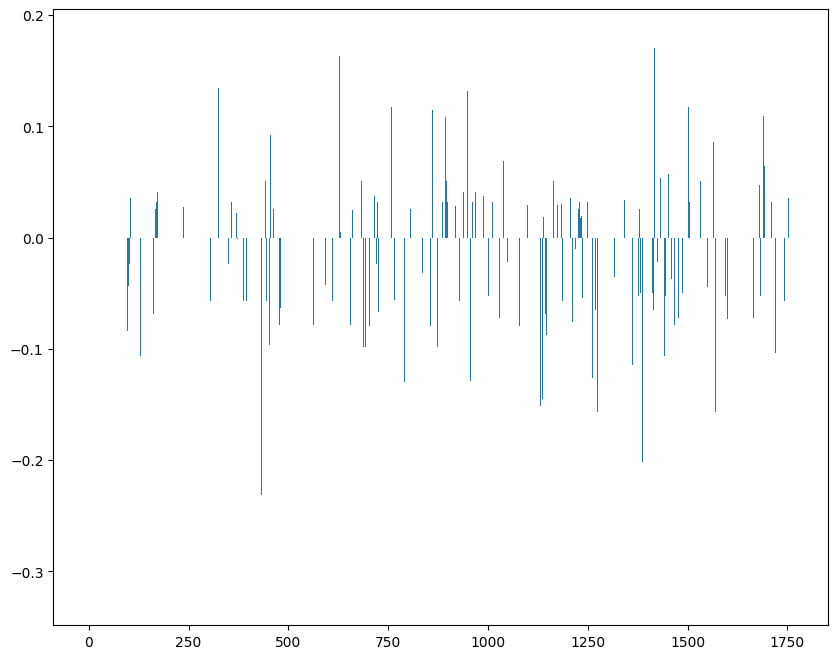

In [20]:
# 학습한 회귀 모델의 계수를 출력
plt.rcParams['figure.figsize'] = [10, 8]

plt.bar(range(len(lr.coef_[0])), lr.coef_[0])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

In [23]:
# 회귀 모델의 계수를 높은 순으로 정렬
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)

# 회귀 모델의 계수를 index_vectorizer에 매핑하여 어떤 형태소인지 출력
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

# 계수가 높은 순으로 피처에 형태소를 맵핑한 결과를 출력
print(str(invert_index_vectorizer)[:100])

{1212: '웨이/Noun', 1614: '팅/Noun', 1657: '하기로/Verb', 1219: '유명한/Adjective', 453: '돈가스/Noun', 1499: '집


In [26]:
# 상위 20개 긍정 형태소를 출력
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

새우/Noun 0.18019141091928803
정말/Noun 0.17015112893474563
맛있습니다/Adjective 0.16313584515747545
너무/Adverb 0.134875852880829
스/Noun 0.13149207883807337
안심/Noun 0.12050002706522882
집이었습니다/Verb 0.11720485776704978
바삭바삭한/Adjective 0.11720485776704978
비쌈/Adjective 0.1148300557454064
끔/Verb 0.1148300557454064
깔/Verb 0.1148300557454064
한번/Noun 0.10971349534611462
살이/Noun 0.10827899445868766
부위/Noun 0.10827899445868766
좋음/Adjective 0.10608504806567137
은/Josa 0.10311754170170277
새우까/Verb 0.10188470518290432
나/Josa 0.10133852505454191
도/Josa 0.09703739028637505
면/Josa 0.09528483110480332
